# Descrição de Atividade

Nesta atividade construiremos modelos preditivos de regressão em scikit learn para a predição dos votos de deputados federais considerando as últimas eleições. As atividades esperadas para essa etapa são descritas a seguir:

Baixe os dados [aqui](https://canvas.instructure.com/courses/1389733/files/69523670/download?verifier=A5EPvssqIQCjlxpWQyesLFer1VDTlRyTAAXR2iyi&wrap=1) (veja descrição dos dados mais abaixo).

Considere o pipeline mostrado nesse [link](https://www.kaggle.com/apapiu/regularized-linear-models) para construir seus modelos de regressão. 

Isso implica, dentre outras coisas:
* Analisar as distribuições das variáveis para ver se estão enviesadas e precisam de correção;
* Fazer tratamento de valores ausentes, variáveis categóricas e normalização, quando for o caso;
* Construir modelos de regressão com (ridge e lasso) e sem regularização;
* Considerar também modelos de regressão não paramétrica como KNN;
* Considerar outros modelos ainda não vistos em sala de sua escolha (e.g. SVR, Regression Trees e Random Florests);
* Tunar os hiperâmetros para cada caso e retornar os rmses de validação cruzada para todos os modelos avaliados;
* Plotar os resíduos versus predições e analisar se esses plots representam bons indícios da adequabilidade dos modelos a esse problema;

Alguns dias antes da entrega final serão liberados os dados de teste referentes à 2014 para validação final dos seus melhores modelos.

_**Dica**: Uma coisa que você pode fazer é usar os dados de 2006 como treino e os de 2010 como validação. Uma vez encontrados os melhores modelos para 2010 junte 2006+2010, retreine, e aplique o modelo aos dados de 2014 que serão liberados._

## Responder:
### Dentre os modelos avaliados, qual foi o que deu o melhor resultado nos dados de 2014 em termos de RMSE? Justifique bem sua resposta.

A entrega deve ser um notebook Jupyter com código python e texto explicativo quando necessário. Crie um repositório na sua conta do github e envie o link do html do notebook.

**Sobre os dados**

Vamos explorar dados sobre as votações que candidatos à Câmara Federal de Deputados receberam nos anos de 2006 e 2010. Esses dados foram extraídos do TSE (Links para um site externo)Links para um site externo, pré-processados e contemplam informações sobre aproximadamente 7.300 candidatos. A descrição de cada atributo é dada mais abaixo.

* **sequencial_candidato**:  (character) id do candidato
* **nome**: (character)
* **uf**: (character)
* **partido**: (character)
* **quantidade_doacoes** : (integer)
* **quantidade_doadores**: (integer) numero de doadores diferentes
* **total_receita**: (double) soma em reais das doacoes
* **media_receita**: (double) media das doacoes
* **recursos_de_outros_candidatos_por_comite**: (double) quantia em reais das doacoes provenientes de outros candidatos ou comite partidário
* **recursos_de_pessoas_fisicas**: (double) quantia em reais das doacoes provenientes de outros CPFs
* **recursos_de_pessoas_juridicas**: (double) quantia em reais das doacoes provenientes de outros CNPJ
* **recursos_proprios**: (double) quantia em reais das doacoes provenientes do proprio candidato
* **recursos_de_partido_politico**: (double) quantia em reais das doacoes provenientes do partido politico do candidato
* **votos**: (integer) variavel alvo. Se refere ao numero de votos na campanha de 2006 e 2010
* **quantidade_despesas**: (integer)
* **quantidade_fornecedores**: (integer) numero de fornecedores por despesas diferentes
* **total_despesa**: (double) soma em reais das despesas de campanha
* **media_despesa**: (double) media das despesas de campanha
* **cargo**: (character)
* **sexo**:  (character)
* **grau**: (character) grau de instrucao do candidato
* **estado_civil**: (character)
* **ocupacao**: (character) ocupacao do candidato

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt

sns.set(style="ticks")

#%matplotlib inline

## Load Data

In [2]:
candidates_df = pd.read_csv('../data/eleicoes_2006_a_2010.csv')
candidates_df.shape

(7330, 23)

## EDA - Exploratory Data Analysis

Inicialmente, devemos fazer uma análise exploratória dos dados para descobrir como eles estão distribuídos, se possuem valores extraordinários (outliers) e se tem alguma correlação mais forte entre si, especialmente com a variável alvo (**votos**).

In [3]:
candidates_df.columns

Index(['ano', 'sequencial_candidato', 'nome', 'uf', 'partido',
       'quantidade_doacoes', 'quantidade_doadores', 'total_receita',
       'media_receita', 'recursos_de_outros_candidatos_comites',
       'recursos_de_pessoas_fisicas', 'recursos_de_pessoas_juridicas',
       'recursos_proprios', 'quantidade_despesas', 'quantidade_fornecedores',
       'total_despesa', 'media_despesa', 'cargo', 'sexo', 'grau',
       'estado_civil', 'ocupacao', 'votos'],
      dtype='object')

In [4]:
candidates_df.describe(exclude=['category', 'object'])

,ano,sequencial_candidato,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos_comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,votos
count,7330.000000,7.330000e+03,7330.000000,7330.000000,7.169000e+03,7169.000000,4.940000e+03,4.647000e+03,3.354000e+03,4.942000e+03,7330.000000,7330.000000,7.330000e+03,7330.000000,7.330000e+03
mean,2008.151160,9.179127e+10,28.310095,25.817462,1.544899e+05,5485.597708,3.002116e+04,3.730931e+04,1.761195e+05,3.914169e+04,133.339836,110.179945,1.588707e+05,1500.033736,2.280617e+04
std,1.994416,9.924629e+10,118.655091,103.659438,3.953880e+05,14116.531491,1.280932e+05,8.215398e+04,3.517541e+05,1.839980e+05,416.838801,338.493008,3.951814e+05,6363.830635,4.810133e+04
min,2006.000000,1.000100e+04,1.000000,1.000000,0.000000e+00,0.000000,2.410000e+00,3.000000e-02,0.000000e+00,0.000000e+00,1.000000,1.000000,0.000000e+00,0.000000,2.000000e+00
25%,2006.000000,1.056500e+04,4.000000,4.000000,2.700000e+03,622.857143,1.180000e+03,2.000000e+03,3.422500e+03,1.177233e+03,6.000000,5.000000,2.781405e+03,398.452936,8.600000e+02
50%,2010.000000,5.000000e+10,9.000000,8.000000,1.209578e+04,1540.542500,3.522570e+03,9.000000e+03,2.612000e+04,5.000000e+03,21.000000,18.000000,1.297986e+04,794.678212,3.025000e+03
75%,2010.000000,1.900000e+11,24.000000,22.000000,8.929956e+04,4662.500000,1.327550e+04,3.756234e+04,1.755218e+05,2.027459e+04,83.000000,71.000000,1.006515e+05,1564.290552,2.027450e+04
max,2010.000000,2.700000e+11,6997.000000,5800.000000,4.539727e+06,500180.000000,3.664205e+06,1.403049e+06,3.178226e+06,5.525600e+06,9932.000000,8359.000000,4.989491e+06,500177.000000,1.353820e+06


A tabela acima já nos permite tirar uma série de insights sobre os dados que temos, entretando precisamos investigar a existência de valores estranhos no nosso dataset, como valores não numéricos em variáveis numéricas:

In [5]:
for col in candidates_df.columns:
    amount_nan = candidates_df[str(col)].isna().sum()
    if amount_nan > 0:
        print("Column [{:02}]: {:40} - Amount NaN: {}".format(candidates_df.columns.get_loc(str(col)), str(col), amount_nan))

Column [07]: total_receita                            - Amount NaN: 161
Column [08]: media_receita                            - Amount NaN: 161
Column [09]: recursos_de_outros_candidatos_comites    - Amount NaN: 2390
Column [10]: recursos_de_pessoas_fisicas              - Amount NaN: 2683
Column [11]: recursos_de_pessoas_juridicas            - Amount NaN: 3976
Column [12]: recursos_proprios                        - Amount NaN: 2388


Para essas variáveis não podemos ter valores não numéricos, então vamos colocar esses valores para 0.0, uma vez que são valores de receita e recursos.

In [6]:
candidates_df.total_receita.fillna(0, inplace=True)
candidates_df.media_receita.fillna(0, inplace=True)
candidates_df.recursos_de_outros_candidatos_comites.fillna(0, inplace=True)
candidates_df.recursos_de_pessoas_fisicas.fillna(0, inplace=True)
candidates_df.recursos_de_pessoas_juridicas.fillna(0, inplace=True)
candidates_df.recursos_proprios.fillna(0, inplace=True)

Como estamos trabalhando com modelos que apenas aceitam variáveis numéricas, precisamos também transformar variáveis categóricas do nosso dataset em variáveis numéricas com as quais nosso modelo de machine learning pode trabalhar. As variáveis não numéricas que temos são as seguintes:

In [7]:
cat_variables = []

for col in candidates_df.columns:
    if not np.issubdtype(candidates_df[str(col)].dtype, np.number) and col != 'nome':
        cat_variables.append(col)
        print("Column [{:02}]: {:40}".format(candidates_df.columns.get_loc(str(col)), str(col)))

Column [03]: uf                                      
Column [04]: partido                                 
Column [17]: cargo                                   
Column [18]: sexo                                    
Column [19]: grau                                    
Column [20]: estado_civil                            
Column [21]: ocupacao                                


Vamos verificar a distribuição dessas variáveis, exceto **nome**, para entender como e se podemos transformar todas para um valor inteiro.

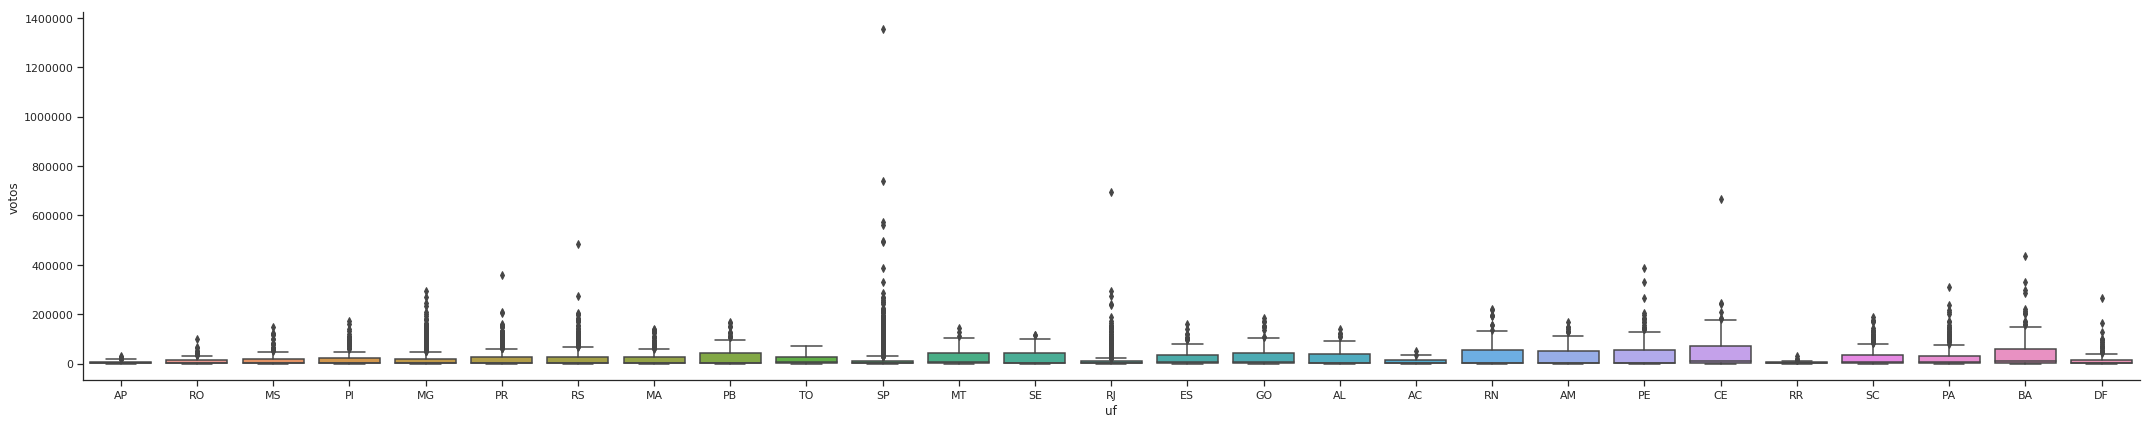

In [8]:
sns.catplot(x='uf', y='votos', data=candidates_df, aspect=5, height=6, kind='box')

Aqui podemos aplicar uma função e transformar cada estado para um código numérico:

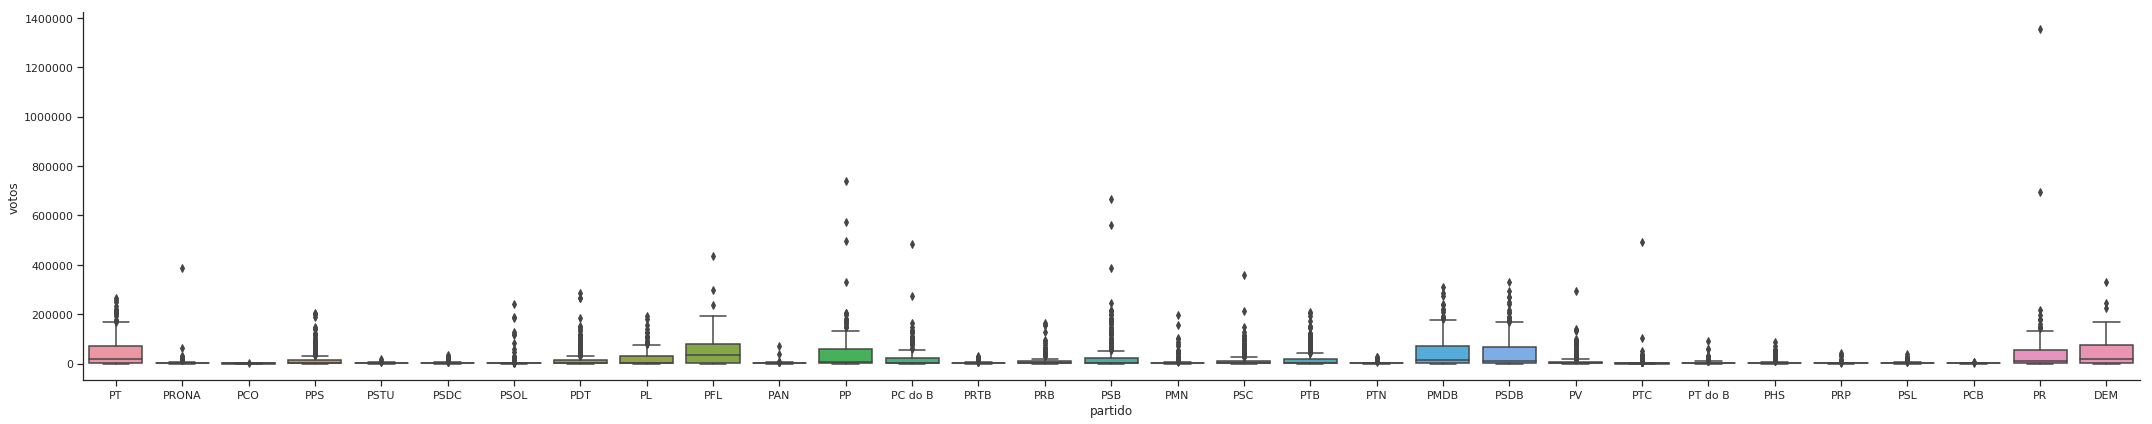

In [9]:
sns.catplot(x='partido', y='votos', data=candidates_df, aspect=5, height=6, kind='box')

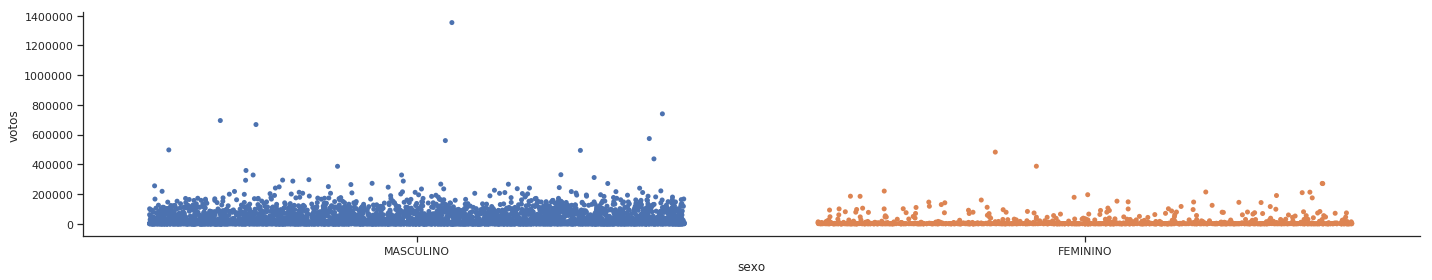

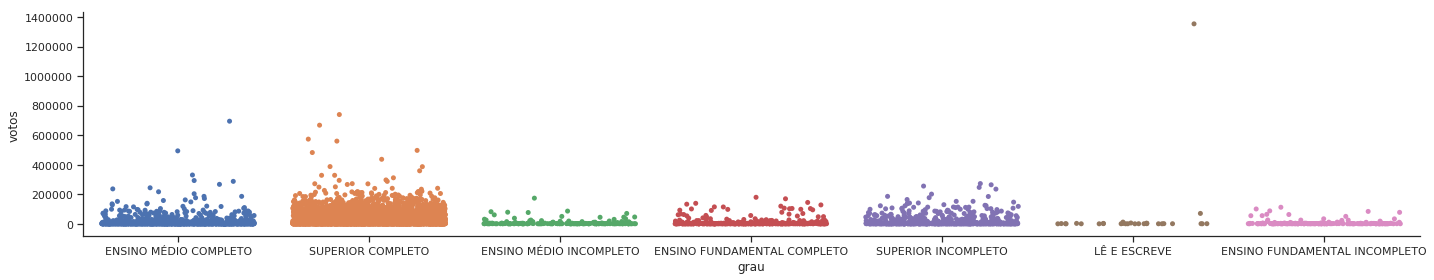

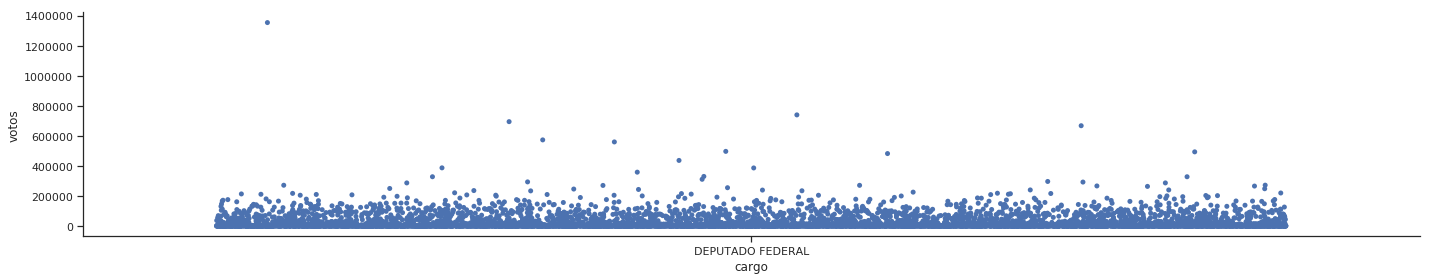

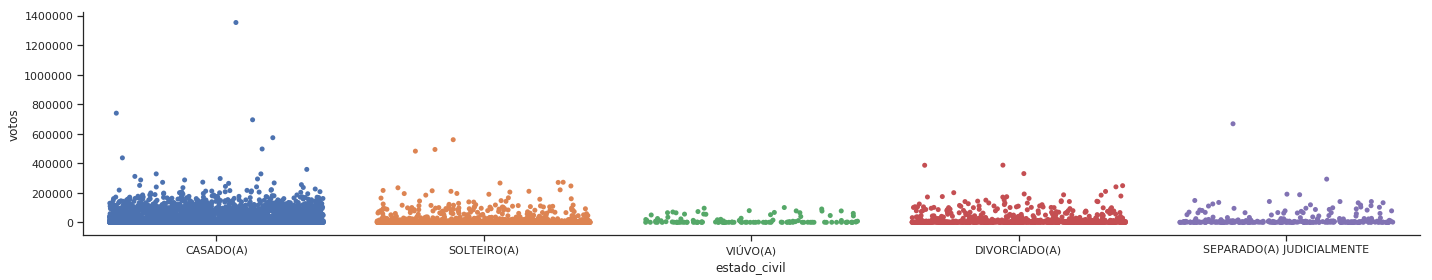

In [10]:
for col in ['sexo', 'grau', 'cargo', 'estado_civil']:
    sns.catplot(x=col, y='votos', data=candidates_df, jitter=.4, aspect=5, height=4)

Note que podemos tratar a variável **grau** como uma variável ordinária:

In [11]:
cleanup_nums = {"grau" : {"LÊ E ESCREVE": 1, 
                       "ENSINO FUNDAMENTAL INCOMPLETO":2, 
                       "ENSINO FUNDAMENTAL COMPLETO":3, 
                       "ENSINO MÉDIO INCOMPLETO":4,
                       "ENSINO MÉDIO COMPLETO":5,
                       "SUPERIOR INCOMPLETO":6,
                       "SUPERIOR COMPLETO": 7}}
candidates_df.replace(cleanup_nums, inplace=True)

candidates_df.grau.head()

0    5
1    7
2    7
3    4
4    3
Name: grau, dtype: int64

Para a variável **ocupacao** nós temos um conjunto muito grande de diferentes valores, o que inviabiliza a exposição gráfica, entretando nós expomos aqui as quantidades para as 20 ocupações mais comuns:

In [12]:
candidates_df.ocupacao.value_counts().head(20)

OUTROS                                            819
DEPUTADO                                          703
ADVOGADO                                          673
EMPRESÁRIO                                        629
VEREADOR                                          326
MÉDICO                                            325
COMERCIANTE                                       316
SERVIDOR PÚBLICO ESTADUAL                         248
SERVIDOR PÚBLICO FEDERAL                          214
PROFESSOR DE ENSINO MÉDIO                         172
ADMINISTRADOR                                     160
ENGENHEIRO                                        158
APOSENTADO (EXCETO SERVIDOR PÚBLICO)              153
POLICIAL MILITAR                                  149
PROFESSOR DE ENSINO SUPERIOR                      148
SERVIDOR PÚBLICO MUNICIPAL                        123
ESTUDANTE, BOLSISTA, ESTAGIÁRIO E ASSEMELHADOS     85
MILITAR REFORMADO                                  80
ECONOMISTA                  

Para transformar essas variáveis categóricas em numéricas (dummy variables), utilizamos uma função especial da biblioteca _pandas_:

In [13]:
candidates_df2 = pd.get_dummies(data=candidates_df, columns=cat_variables)
candidates_df2.shape

(7330, 264)

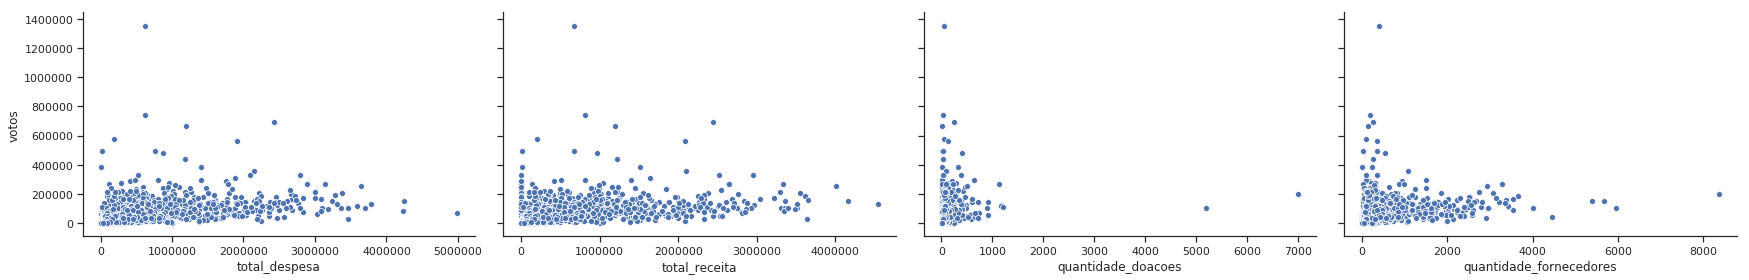

In [14]:
sns.pairplot(candidates_df, x_vars=['total_despesa', 'total_receita', 'quantidade_doacoes', 'quantidade_fornecedores'], y_vars=['votos'], aspect=1.5, height=4)

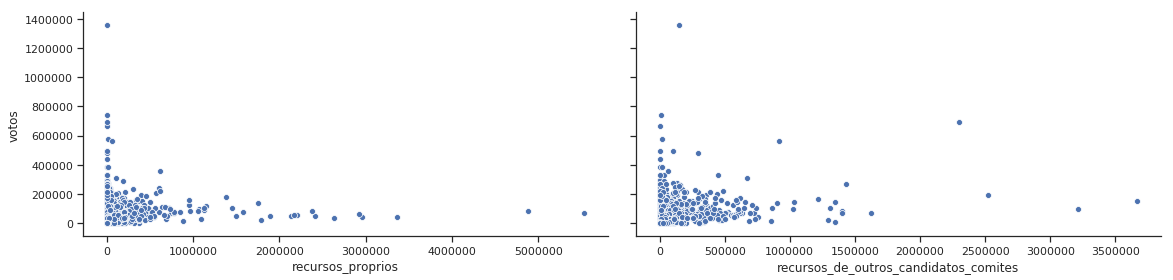

In [15]:
sns.pairplot(candidates_df, x_vars=['recursos_proprios', 'recursos_de_outros_candidatos_comites'], y_vars=['votos'], aspect=2, height=4)

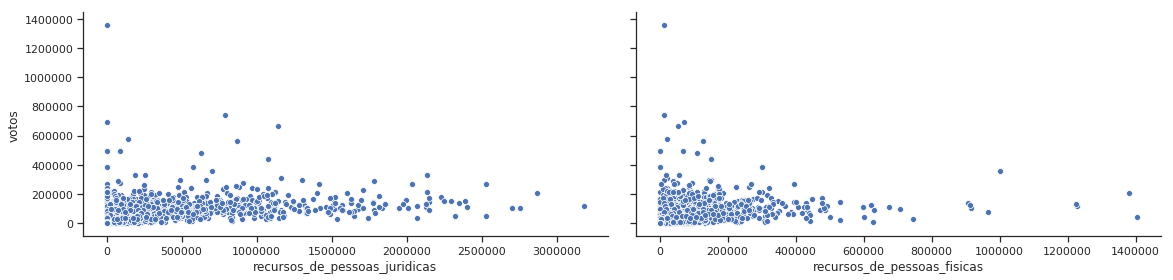

In [16]:
sns.pairplot(candidates_df, x_vars=['recursos_de_pessoas_juridicas', 'recursos_de_pessoas_fisicas'], y_vars=['votos'], aspect=2, height=4)